In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import h5py
import torch

import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
np.set_printoptions(precision=2, suppress=False)

cuda:0


Predicting using validation folder delta-0.00_kappa-0.88
Loaded state dict from file


[(0.0, 1.0), (0.0, 1.0)]

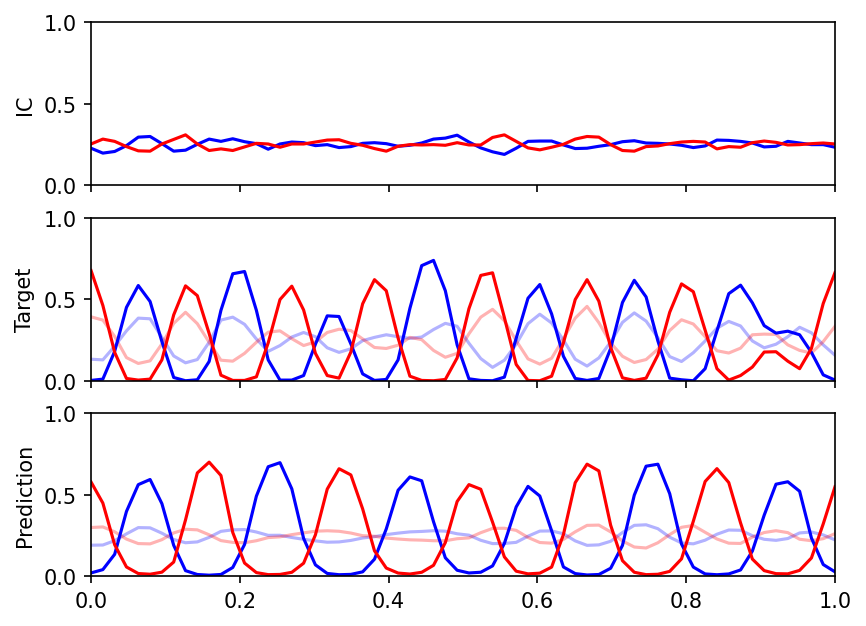

In [2]:
import torch
import json
import os
import pandas as pd
from pprint import pprint
from forecasting_dataset import SimulationDataset
from forecasting_nn import SimulationForecasting

device = torch.device('cuda:0')

model_path = 'models/simulation/SimulationForecasting_segregated'

# Get validation set simulation
with open(f'{model_path}_args.txt', 'r') as f:
    info = json.load(f)
folder = info['val_folder'][1]
print(f'Predicting using validation folder {os.path.basename(folder)}')
ds = SimulationDataset(folder, seq_len=50)

# Load model
info = torch.load(f'{model_path}.ckpt')
model = SimulationForecasting().to(device)
model.load_state_dict(info['state_dict'])
model.eval()
print('Loaded state dict from file')

sample = ds[3]

fig, ax = plt.subplots(3, 1, dpi=150, sharex=True, sharey=True)

ax[0].plot(ds.x, sample['ab'][0,0], color='blue')
ax[0].plot(ds.x, sample['ab'][0,1], color='red')
ax[0].set_ylabel('IC')

ax[1].plot(ds.x, sample['ab'][5,0], color='blue', alpha=0.3)
ax[1].plot(ds.x, sample['ab'][5,1], color='red', alpha=0.3)
ax[1].plot(ds.x, sample['ab'][40,0], color='blue')
ax[1].plot(ds.x, sample['ab'][40,1], color='red')
ax[1].set_ylabel('Target')

ab1 = model.simulate(sample['ab'][0:1].to(device), ds.seq_len)[0]
ab1 = ab1.detach().cpu().numpy()

ax[2].plot(ds.x, ab1[5,0], color='blue', alpha=0.3)
ax[2].plot(ds.x, ab1[5,1], color='red', alpha=0.3)
ax[2].plot(ds.x, ab1[40,0], color='blue')
ax[2].plot(ds.x, ab1[40,1], color='red')
ax[2].set_ylabel('Prediction')

ax[0].set(xlim=[0,1], ylim=[0,1])

In [55]:
from tqdm.auto import tqdm

def compute_saliency(model, ab):
    '''
    Make predictions of the time derivative for each time point in sample
    Compute saliency using those predictions
    model is a neural network whose forward function predicts the time derivative
    ab is a [T, C, L] shaped FloatTensor which is a time series of occupation fractions
    '''
    loc = torch.zeros(ab.shape[-1], dtype=ab.dtype, device=ab.device)
    G_S_shifted = []
    for tt in tqdm(range(ab.shape[0])):
        G_S = []
        inputs = ab[tt:tt+1].clone()
        inputs.requires_grad = True
        dt_ab = model(inputs)
        for xx in range(dt_ab.shape[2]):
            loc[:] = 0.
            loc[xx] = 1.
            grad = []
            for cc in range(dt_ab.shape[1]):
                grad.append(
                    torch.autograd.grad(dt_ab[0,cc], inputs, grad_outputs=loc, retain_graph=True)[0]
                )
            grad = torch.cat(grad, dim=0) # [C, C, L]
            G_S.append(grad.detach().cpu().numpy())
        
        center = dt_ab.shape[-1] // 2
        shifts = center - np.arange(dt_ab.shape[-1], dtype=int)
        G_S_shifted.append(np.asarray([np.roll(g, shift, axis=-1) for shift, g in zip(shifts, G_S)]))
    
    return np.array(G_S_shifted) #[T, L, C, C, L]

import torch
import torch.nn as nn
import torch.nn.functional as F

class AverageFilter(nn.Module):
    def forward(self, x):
        return 10 * torch.mean(x, dim=-1, keepdims=True).expand_as(x)

class GaussianFilter(nn.Module):
    def __init__(self, size=25, sigma=1.):
        super().__init__()
        xx = torch.linspace(-size//2, size//2, size, dtype=torch.float)
        kernel = torch.exp(-xx**2/(2*sigma**2)) / np.sqrt(2*np.pi*sigma**2)
        kernel = torch.eye(2, dtype=torch.float)[...,None] * kernel[None, None]
        self.kernel = nn.Parameter(kernel)

    def forward(self, x):
        return F.conv1d(x, self.kernel, padding='same')    

models = {
    'gaussian_narrow': GaussianFilter(size=25, sigma=1.),
    'gaussian_broad': GaussianFilter(size=45, sigma=6.),
    'average': AverageFilter(),
}

for model_name in models:
    model = models[model_name].to(device)
    sample = ds[0]
    ab = sample['ab'].to(device)

    G_S_shifted = compute_saliency(model, ab[:10])
    np.save(f'models/simulation/{model_name}_saliency.npy', G_S_shifted)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 23.98it/s]


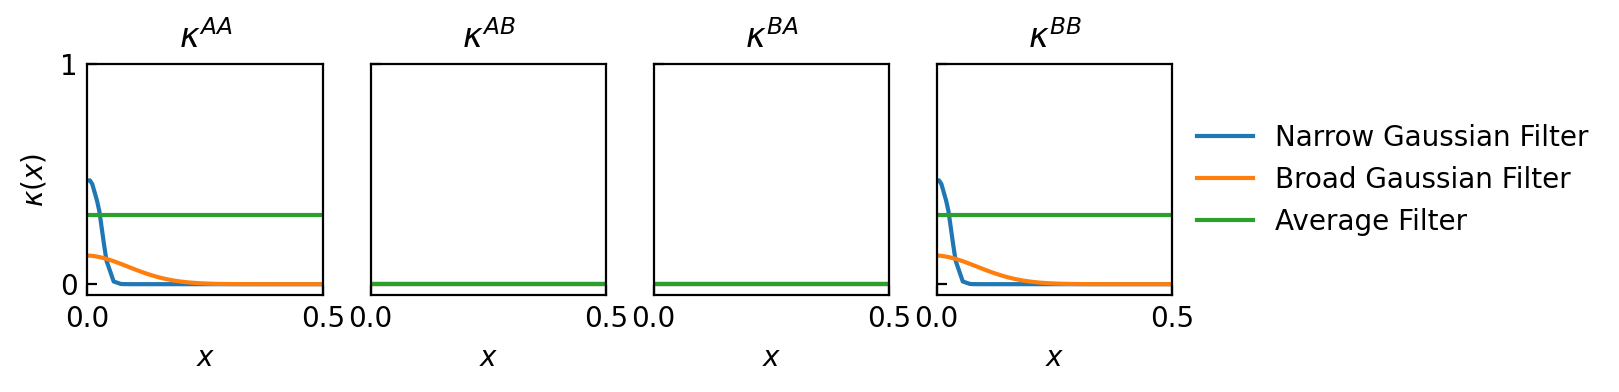

In [56]:
from scipy.interpolate import interp1d

xx = ds.x - ds.x.mean()
xmin = 0.
xmax = xx.max()
x_plot = np.linspace(xmin, xmax, 100)

labels = {
    'gaussian_narrow': 'Narrow Gaussian Filter',
    'gaussian_broad': 'Broad Gaussian Filter',
    'average': 'Average Filter',
}

fig, ax = plt.subplots(1, 4, dpi=200, 
    figsize=(7, 1.5),
    sharex=True, sharey=True)

for model_name in labels:
    G_S_shifted = np.load(f'models/simulation/{model_name}_saliency.npy', 
                          mmap_mode='r')

    for ii in range(2):
        for jj in range(2):
            Gr = np.mean(G_S_shifted[:, :, ii, jj], axis=(0, 1))
            Gr = interp1d(xx, Gr + Gr[::-1])
            Gr = Gr(x_plot)
            ax[2*ii+jj].plot(x_plot, Gr, label=labels[model_name])

for a in ax:
    a.set(
        xlim=[xmin, xmax],
        xlabel='$x$',
        xticks=[0, 0.5],
        ylim=[-0.05, 1],
        yticks=[0, 1]
    )
    a.tick_params(which='both', direction='in')

ax[0].set_ylabel(r'$\kappa(x)$')
ax[0].set_title(r'$\kappa^{AA}$')
ax[1].set_title(r'$\kappa^{AB}$')
ax[2].set_title(r'$\kappa^{BA}$')
ax[3].set_title(r'$\kappa^{BB}$')
ax[3].legend(loc='center left', bbox_to_anchor=[1, 0.5], framealpha=0.)
